# Problem 10.10

**Fundamentals of Solar Cells and Photovoltaic Systems Engineering**

**Solutions Manual - Chapter 10**

**Problem 10.10**

**In this problem, we will reflect on the impact of the DC/AC ratio for horizontal single-axis trackers (HSAT). To that end, let us assume that the DC generation of the PV power plant is proportional to the irradiance on the PV modules. For the sake of simplicity, we neglect here other effects such as solar cell temperature.**

**Using the Typical Meteorological Year (TMY), estimate the percentage of energy that would be curtailed for the location described in Problem 10.1 (latitude and longitude 40.371944⁰N, -3.7825⁰W) assuming tilt angle of 30⁰ if the DC/AC ratio is equal to 1, 1.2 and 1.4.**

We will use the packages [pvlib](https://pvlib-python.readthedocs.io/en/stable/), [pandas](https://pandas.pydata.org/) and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results. We will also use the package [pytz](https://pypi.org/project/pytz/) to determine the time zone of the location (Madrid).

In [1]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import numpy as np

We start by defining the location, date, and time. 

In [2]:
# Cuatro Vientos, Madrid, Spain
lat, lon =  40.371944, -3.7825
#altitude = 22

tz = pytz.timezone('Europe/Madrid')
# location
location = pvlib.location.Location(lat, lon, tz=tz)

We retrieve typical meteorological year (TMY) data from PVGIS.

In [3]:
tmy, _, _, _ = pvlib.iotools.get_pvgis_tmy(latitude=lat, longitude=lon, map_variables=True)

tmy.index = tmy.index.tz_convert(tz) # use local time

We calculate the Sun's coordinates 

In [4]:
# calculate Sun's coordinates
solar_position = location.get_solarposition(times=tmy.index)

We need to calculate the orientation and tilt of the PV modules in the horizontal single-axis tracker. 

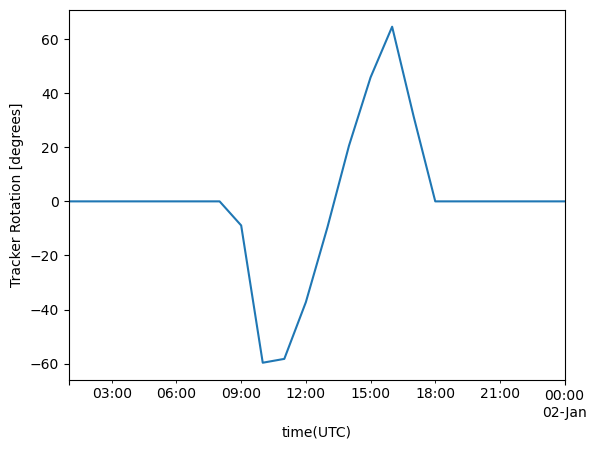

In [5]:
tracker_data = pvlib.tracking.singleaxis(
                solar_position['apparent_zenith'],
                solar_position['azimuth'],
                axis_azimuth=180)  # axis is aligned N-S
tilt = tracker_data['surface_tilt'].fillna(0)
orientation = tracker_data['surface_azimuth'].fillna(0)

# plot a day to illustrate:
tracker_data['tracker_theta'].fillna(0).head(24).plot()
plt.ylabel('Tracker Rotation [degrees]');

We calculate the annual radiation (or reference yield) on the PV modules.

In [6]:
# calculate irradiante at the plane of the array (poa)
poa_irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                        surface_azimuth=orientation,
                                                        dni=tmy['dni'],
                                                        ghi=tmy['ghi'],
                                                        dhi=tmy['dhi'],
                                                        solar_zenith=solar_position['apparent_zenith'],
                                                        solar_azimuth=solar_position['azimuth'])    

We calculate the percentage of energy lost for different DC/AC ratio.

In [7]:
for DC_AC in [1, 1.2, 1.4]:
    available_G = poa_irradiance['poa_global']
    used_G = available_G.copy()
    used_G[used_G>1000/DC_AC]=1000/DC_AC
    ratio = (available_G.sum()-used_G.sum())/available_G.sum()
    print("For DC/AC ratio = " + str(DC_AC) + ', curtailed energy represents ' + str(round(ratio*100,2)) + '% of available energy')

For DC/AC ratio = 1, curtailed energy represents 0.02% of available energy
For DC/AC ratio = 1.2, curtailed energy represents 4.5% of available energy
For DC/AC ratio = 1.4, curtailed energy represents 11.37% of available energy


We can make a plot with the curtailed energy as a function of the DC/AC ratio. 

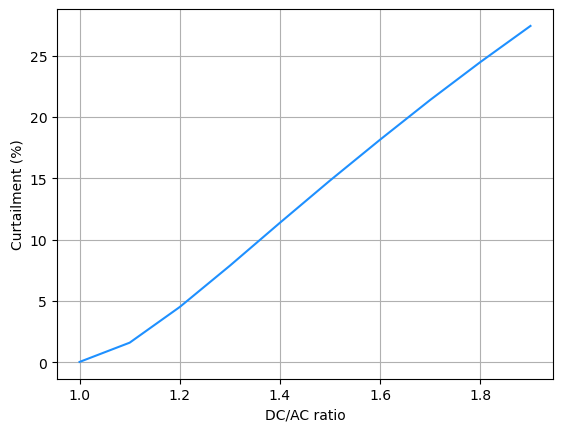

In [8]:
ratio = pd.Series(dtype=float)
for DC_AC in np.arange(1,2,0.1):
    available_G = poa_irradiance['poa_global']
    used_G = available_G.copy()
    used_G[used_G>1000/DC_AC]=1000/DC_AC
    ratio[DC_AC] = 100*(available_G.sum()-used_G.sum())/available_G.sum()

ratio.plot(color='dodgerblue')
plt.ylabel('Curtailment (%)')
plt.xlabel('DC/AC ratio')
plt.grid()